# Initial Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

df = pd.read_csv("./kieranFeatures_1-30_26-Sep-2024.csv")
df.head()

,ID,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,...,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23,adjSA1,adjSA2,adjSA3,adjSAtotal
0,5,-0.123031,-0.226077,-1.220480,-1.697738,-0.273200,-0.601171,-0.809518,-1.012558,-0.299118,...,-1.877017,-1.442056,1.070298,1.277417,0.249605,0.400156,0.119790,1.593122,-0.800726,0.350233
1,5,-0.152896,-0.050866,1.527067,1.883468,-0.378060,-0.018812,1.023216,1.189124,-0.355315,...,-1.632698,-1.531970,1.779032,1.074498,0.409991,0.333842,0.075246,-1.663383,0.859309,-0.262893
2,5,-0.166035,-0.181478,1.634437,0.904620,-0.424192,-0.452936,1.123414,0.534554,-0.380039,...,-1.489450,-1.448590,2.194570,1.262672,0.504028,0.395338,-1.072729,0.879836,-1.542415,-0.938513
3,5,-0.231095,-0.209571,1.654951,1.247081,-0.652624,-0.546311,1.214370,0.821624,-0.502463,...,-1.353433,-1.059878,2.589134,2.139926,0.593317,0.682023,-0.643181,-0.217332,0.945816,0.145041
4,5,-0.236090,-0.323013,-0.478244,-1.080788,-0.670161,-0.923364,-0.421866,-0.775114,-0.511862,...,-1.443846,-0.627980,2.326862,3.114644,0.533965,1.000560,-0.323098,0.712401,-1.473404,-0.642872


# Pre-Processing

Divide up dataframe into predictors and outcomes. Train-test-split the following data.

In [12]:
# Create binary variables for high and low 
adj_SA_1_median = np.median(df["adjSA1"])
adj_SA_2_median = np.median(df["adjSA2"])
adj_SA_3_median = np.median(df["adjSA3"])
adj_SA_tot_median = np.median(df["adjSAtotal"])

# Will be high if adjusted SA level score is equal to or above median, low otherwise
df["Lv_1_Hi"] = (df["adjSA1"] >= adj_SA_1_median).astype(int)
df["Lv_2_Hi"] = (df["adjSA2"] >= adj_SA_2_median).astype(int)
df["Lv_3_Hi"] = (df["adjSA3"] >= adj_SA_3_median).astype(int)
df["Tot_Hi"] = (df["adjSAtotal"] >= adj_SA_tot_median).astype(int)

In [3]:
predictors_df = df.iloc[:, 1:(df.shape[1] - 8)]
outcomes_df = df.iloc[:, (df.shape[1] - 8):]

# Split into train and test
predictors_train, predictors_test, outcomes_train, outcomes_test = train_test_split(predictors_df, outcomes_df, test_size = 0.2, random_state = 42)

# Scale the data
scaler = StandardScaler()
predictors_train = scaler.fit_transform(predictors_train)
predictors_train = pd.DataFrame(predictors_train, columns = predictors_df.columns)
predictors_test = scaler.transform(predictors_test)
predictors_test = pd.DataFrame(predictors_test, columns = predictors_df.columns)

predictors_train_100 = predictors_train.sample(axis = "columns", n = 100, random_state = 42, replace = False)
predictors_test_100 = predictors_test.sample(axis = "columns", n = 100, random_state = 42, replace = False)

# Free up memory
del df

# Training Models

In [17]:
def n_features_cv_scores(df, n, folds):
    # Pre-Processing
    # Separating predictors and outcomes
    predictors_df = df.iloc[:, 1:(df.shape[1] - 8)]
    predictors_df = predictors_df.sample(axis = "columns", n = n, replace = False)
    outcomes_df = df.iloc[:, (df.shape[1] - 8):]

    # Split into train and test
    predictors_train, predictors_test, outcomes_train, outcomes_test = train_test_split(predictors_df, outcomes_df, test_size = 0.2)

    # Scale the data
    scaler = StandardScaler()
    predictors_train = scaler.fit_transform(predictors_train)
    predictors_train = pd.DataFrame(predictors_train, columns = predictors_df.columns)
    predictors_test = scaler.transform(predictors_test)
    predictors_test = pd.DataFrame(predictors_test, columns = predictors_df.columns)

    # Training Models
    # Setup models to train
    SA_1_LogReg = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
    SA_2_LogReg = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
    SA_3_LogReg = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
    SA_tot_LogReg = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)

    scores = {
        "SA_1": np.mean(cross_val_score(SA_1_LogReg, predictors_train, outcomes_train["Lv_1_Hi"], cv = folds, scoring = "accuracy", n_jobs = -1)),
        "SA_2": np.mean(cross_val_score(SA_2_LogReg, predictors_train, outcomes_train["Lv_2_Hi"], cv = folds, scoring = "accuracy", n_jobs = -1)),
        "SA_3": np.mean(cross_val_score(SA_3_LogReg, predictors_train, outcomes_train["Lv_3_Hi"], cv = folds, scoring = "accuracy", n_jobs = -1)),
        "SA_Tot": np.mean(cross_val_score(SA_tot_LogReg, predictors_train, outcomes_train["Tot_Hi"], cv = folds, scoring = "accuracy", n_jobs = -1))
    }

    return scores 

def n_features_test_accuracy(df, n, iters):
    SA_1_scores = []
    SA_2_scores = []
    SA_3_scores = []
    SA_tot_scores = []

    for _ in range(iters):
        # Pre-Processing
        # Separating predictors and outcomes
        predictors_df = df.iloc[:, 1:(df.shape[1] - 8)]
        predictors_df = predictors_df.sample(axis = "columns", n = n, replace = False)
        outcomes_df = df.iloc[:, (df.shape[1] - 8):]

        # Split into train and test
        predictors_train, predictors_test, outcomes_train, outcomes_test = train_test_split(predictors_df, outcomes_df, test_size = 0.2)

        # Scale the data
        scaler = StandardScaler()
        predictors_train = scaler.fit_transform(predictors_train)
        predictors_train = pd.DataFrame(predictors_train, columns = predictors_df.columns)
        predictors_test = scaler.transform(predictors_test)
        predictors_test = pd.DataFrame(predictors_test, columns = predictors_df.columns)



        # Training Models
        # Setup models to train
        SA_1_LogReg = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
        SA_2_LogReg = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
        SA_3_LogReg = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
        SA_tot_LogReg = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)

        # Fit all models
        SA_1_LogReg.fit(predictors_train, outcomes_train["Lv_1_Hi"])
        SA_2_LogReg.fit(predictors_train, outcomes_train["Lv_2_Hi"])
        SA_3_LogReg.fit(predictors_train, outcomes_train["Lv_3_Hi"])
        SA_tot_LogReg.fit(predictors_train, outcomes_train["Tot_Hi"])



        # Model Evaluation
        # Get predictions for all models
        SA_1_preds = SA_1_LogReg.predict(predictors_test)
        SA_2_preds = SA_1_LogReg.predict(predictors_test)
        SA_3_preds = SA_1_LogReg.predict(predictors_test)
        SA_tot_preds = SA_1_LogReg.predict(predictors_test)

        # Append accuracy scores
        SA_1_scores.append(accuracy_score(SA_1_preds, outcomes_test["Lv_1_Hi"]))
        SA_2_scores.append(accuracy_score(SA_2_preds, outcomes_test["Lv_2_Hi"]))
        SA_3_scores.append(accuracy_score(SA_3_preds, outcomes_test["Lv_3_Hi"]))
        SA_tot_scores.append(accuracy_score(SA_tot_preds, outcomes_test["Tot_Hi"]))

    scores = {
        "SA_1": np.mean(SA_1_scores),
        "SA_2": np.mean(SA_2_scores),
        "SA_3": np.mean(SA_3_scores),
        "SA_Tot": np.mean(SA_tot_scores)
    }

    return scores 

In [42]:
n_vals = [100, 500, 1000, 2500, 5815]

cv_scores = {
    "SA_1": [],
    "SA_2": [],
    "SA_3": [],
    "SA_Tot": []
}

accuracy_scores = {
    "SA_1": [],
    "SA_2": [],
    "SA_3": [],
    "SA_Tot": []
}

# Get CV Scores from different n features
for n in n_vals:
    n_cv_scores = n_features_cv_scores(df, n, 10)

    cv_scores["SA_1"].append(n_cv_scores["SA_1"])
    cv_scores["SA_2"].append(n_cv_scores["SA_2"])
    cv_scores["SA_3"].append(n_cv_scores["SA_3"])
    cv_scores["SA_Tot"].append(n_cv_scores["SA_Tot"])

    n_accuracy_scores = n_features_test_accuracy(df, n, 5)

    accuracy_scores["SA_1"].append(n_accuracy_scores["SA_1"])
    accuracy_scores["SA_2"].append(n_accuracy_scores["SA_2"])
    accuracy_scores["SA_3"].append(n_accuracy_scores["SA_3"])
    accuracy_scores["SA_Tot"].append(n_accuracy_scores["SA_Tot"])

cv_scores_df = pd.DataFrame(data = cv_scores, index = n_vals)
test_accuracy_scores_df = pd.DataFrame(data = accuracy_scores, index = n_vals)

<BarContainer object of 5 artists>

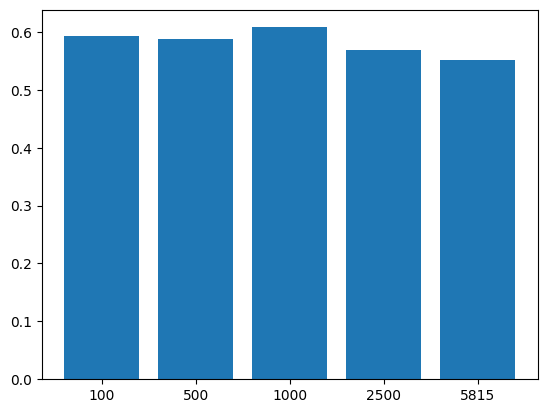

In [45]:
# Plotting Results
plt.bar([str(n) for n in n_vals], cv_scores_df["SA_1"].values)
# plt.xticks()

In [32]:
cv_scores_df

,SA_1,SA_2,SA_3,SA_Tot
100,0.559667,0.522667,0.551333,0.514000
500,0.534500,0.588167,0.572500,0.629667
1000,0.617167,0.551667,0.523167,0.605167
2500,0.613500,0.543333,0.563833,0.641167
5815,0.547167,0.605000,0.566833,0.633167


In [4]:
SA_1_LogReg_all = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
SA_1_LogReg_all.fit(predictors_train, outcomes_train["Lv_1_Hi"])

# SA_2_LogReg_5000 = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
# SA_2_LogReg_5000.fit(predictors_train_5000, outcomes_train["Lv_2_Hi"])

# SA_3_LogReg_5000 = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
# SA_3_LogReg_5000.fit(predictors_train_5000, outcomes_train["Lv_3_Hi"])

# SA_tot_LogReg_5000 = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
# SA_tot_LogReg_5000.fit(predictors_train_5000, outcomes_train["Tot_Hi"])

SA_1_LogReg_100 = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
SA_1_LogReg_100.fit(predictors_train_100, outcomes_train["Lv_1_Hi"])

# SA_2_LogReg_100 = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
# SA_2_LogReg_100.fit(predictors_train_100, outcomes_train["Lv_2_Hi"])

# SA_3_LogReg_100 = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
# SA_3_LogReg_100.fit(predictors_train_100, outcomes_train["Lv_3_Hi"])

# SA_tot_LogReg_100 = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
# SA_tot_LogReg_100.fit(predictors_train_100, outcomes_train["Tot_Hi"])

LogisticRegression(fit_intercept=False, max_iter=10000, n_jobs=-1)

# Evaluating Model Performance (Accuracy)

In [5]:
def get_eval_metrics(model, predictors, outcome, display_labels):
    """
        Plots confusion matrix and ROC-AUC curve for a fitted sklearn model

        Parameters:
            model (sklearn Model): sklearn model to predict outcome values
            predictors (DataFrame): pandas Dataframe containing all predictor features
            outcome (Series): pandas Series containing all values for the outcome variable
            display_labels (list(str)): List of 2 strings for labeling the 0 and 1 outputs for confusion matrix

        Return:
            None
    """
    
    predicted_outcomes = model.predict(predictors)
    print("Accuracy: ", accuracy_score(predicted_outcomes, outcome))

    # Confusion Matrix
    predicted_outcomes = model.predict(predictors)
    cm = metrics.confusion_matrix(outcome, predicted_outcomes)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = display_labels)
    cm_display.plot()
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = metrics.roc_curve(outcome, predicted_outcomes)
    roc_auc  = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label = "ROC Curve (area = %0.3f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--") # Random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

Accuracy:  0.4918032786885246


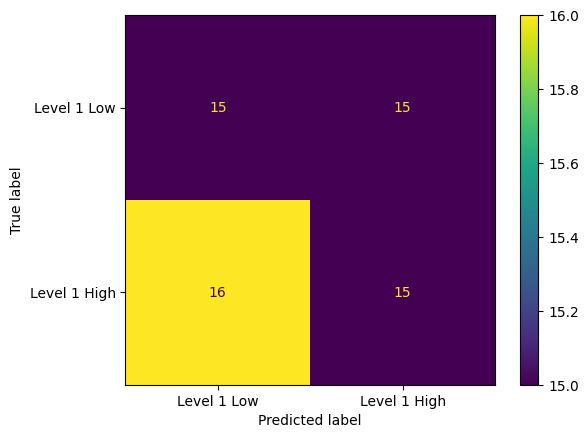

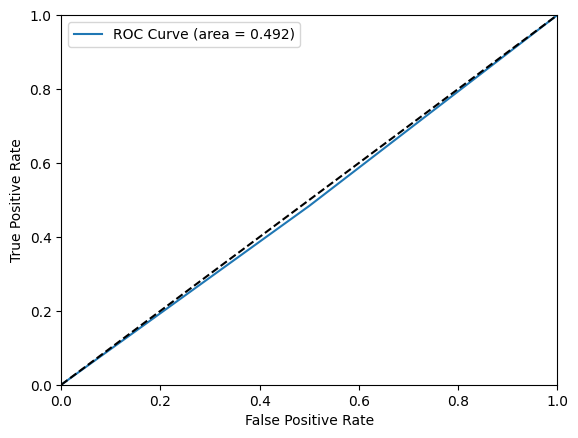

In [6]:
get_eval_metrics(SA_1_LogReg_all, predictors_test, outcomes_test["Lv_1_Hi"], ["Level 1 Low", "Level 1 High"])

Accuracy:  0.6229508196721312


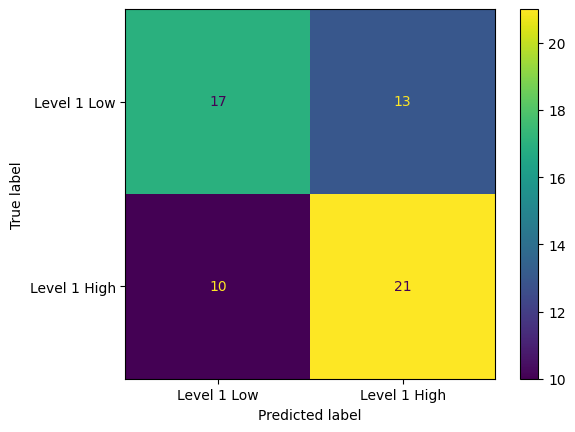

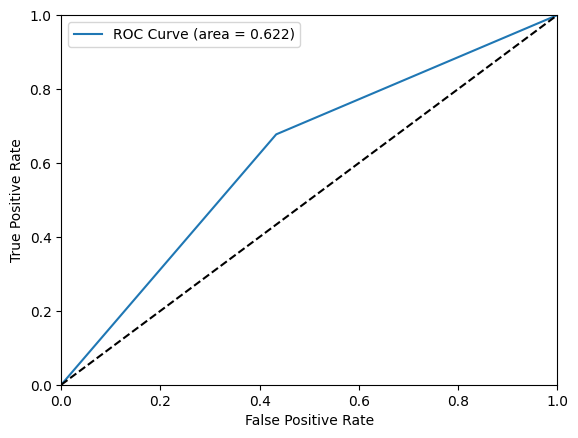

In [7]:
get_eval_metrics(SA_1_LogReg_100, predictors_test_100, outcomes_test["Lv_1_Hi"], ["Level 1 Low", "Level 1 High"])